# Lab 2 (Part 1): Image classification with MLPs


------------------------------------------------------
*Deep Learning. Master in Information Health Engineering *

*Pablo M. Olmos pamartin@ing.uc3m.es*

------------------------------------------------------


In this second lab of the course, you will implement an image classifier using MLPs. We will use the MNIST dataset, which consists of greyscale handwritten digits. Each image is 28x28 pixels, you can see a sample below

In [1]:
from IPython.display import Image
from IPython.core.display import HTML 

Image(url= "https://upload.wikimedia.org/wikipedia/commons/2/27/MnistExamples.png", width=400, height=200)

Our goal is to build a neural network that can take one of these images and predict the digit in the image.

Note: a big part of the following material is a personal wrap-up of [Facebook's Deep Learning Course in Udacity](https://www.udacity.com/course/deep-learning-pytorch--ud188). So all credit goes for them!!

In [0]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  #To get figures with high quality!

import numpy as np
import torch
from torch import nn
from torch import optim
import matplotlib.pyplot as plt

## Part I. Download MNIST with `torchvision`

First up, we need to get our dataset. This is provided through the `torchvision` package. The [torchvision package](https://pytorch.org/docs/stable/torchvision/index.html) consists of popular datasets, model architectures, and common image transformations for computer vision.


The code below will download the MNIST dataset, then create training and test datasets for us. Don't worry too much about the details here, you'll learn more about this later.

In [3]:
### Run this cell

from torchvision import datasets, transforms

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])

# Download and load the training  data
trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

0it [00:00, ?it/s]

9920512it [00:08, 1199539.30it/s]                             


Extracting /root/.pytorch/MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw


0it [00:00, ?it/s]

32768it [00:00, 57177.68it/s]                           
0it [00:00, ?it/s]

Extracting /root/.pytorch/MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw


1654784it [00:01, 878145.51it/s]                             
0it [00:00, ?it/s]

Extracting /root/.pytorch/MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw


8192it [00:00, 21656.17it/s]            

Extracting /root/.pytorch/MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw
Processing...
Done!


We have the training data loaded into `trainloader` and we make that an iterator with `iter(trainloader)`. Later, we'll use this to loop through the dataset for training, like

```python
for image, label in trainloader:
    ## do things with images and labels
```

You'll notice I created the `trainloader` with a batch size of 64, and `shuffle=True`. The batch size is the number of images we get in one iteration from the data loader and pass through our network, often called a *batch*. And `shuffle=True` tells it to **shuffle the dataset every time we start going through the data loader again**. But here I'm just grabbing the first batch so we can check out the data. We can see below that `images` is just a tensor with size `(64, 1, 28, 28)`. So, 64 images per batch, **1 color channel**, and 28x28 images.

In [4]:
dataiter = iter(trainloader)   #To iterate through the dataset

images, labels = dataiter.next()
print(type(images))
print(images.shape)
print(labels.shape)


<class 'torch.Tensor'>
torch.Size([64, 1, 28, 28])
torch.Size([64])


This is what one of the images looks like. 

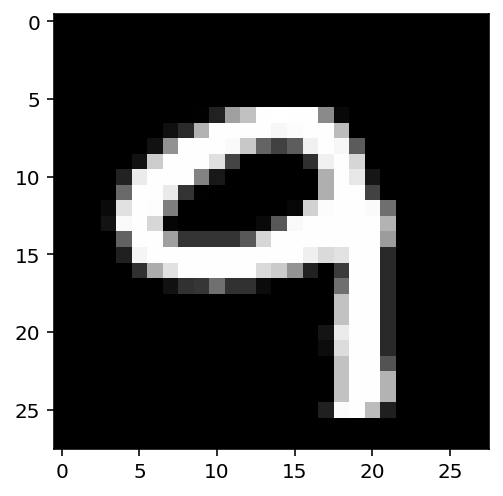

In [5]:
plt.imshow(images[1].numpy().reshape([28,28]), cmap='Greys_r')

## Part II. Train a multi-class Logistic Regressor

Our first goal is to train a multi-class logistic regressor to evaluate how got it can do in both the training and the test sets. 

The following code is **almost identical** to the one you used for Lab 1 except for two small details:

- We are training a LR classifier with 10 different outputs that implements a **softmax** non-linear function (instead of a binary LR with a sigmoid). 

- We are using the MNIST database loaded above.

We first define the Multi-class Logistic Regressor class

> **Exercise**: Complete the following code

In [0]:
class Multi_LR(nn.Module):
    def __init__(self,dimx,nlabels): #Nlabels will be 10 in our case
        super().__init__()
        
        self.output = nn.Linear(dimx,nlabels)
    
         
        self.logsoftmax = nn.LogSoftmax(dim=1)     # NEW w.r.t Lab 1. dim is the dimension along which 
                                                #Softmax will be computed (so every slice along dim will sum to 1)
        
    def forward(self, x):
        # Pass the input tensor through each of our operations
        x =  self.output(x)
        x =  self.logsoftmax(x)
        return x

Note that we use `nn.LogSoftmax` instead of `nn.Softmax()`. In many cases, softmax gives you probabilities which will often be very close to zero or one but floating-point numbers can't accurately represent values near zero or one ([read more here](https://docs.python.org/3/tutorial/floatingpoint.html)). It's usually best to avoid doing calculations with probabilities, typically we use log-probabilities.  The cross entropy loss is obtained by combining `nn.LogSoftmax` with the negative loss likelihood loss `nn.NLLLoss()`.

Alternatively, we can use [`nn.CrossEntropyLoss`](https://pytorch.org/docs/stable/nn.html#torch.nn.CrossEntropyLoss). **This criterion combines `nn.LogSoftmax()` and `nn.NLLLoss()` in one single class.**

This means we need to pass in the raw output of our network into the loss, not the output of the softmax function. This raw output is usually called the *logits* or *scores*.


Now we implement an extension to the class above (which inheritates from `Multi_LR`) that includes a training method.  One thing, note that MNIST images are of dimension $28\times28=784$. To feed this image as the input to a `nn.Linear` layer, it has to be converted to a $784\times 1$ input tensor. 

> **Exercise**: Complete the following code

In [0]:
''' This class inherits from the `Multi_LR` class. So it has the same atributes
and methods, and some others that we will add. 
'''
class Multi_LR_extended(Multi_LR):
    
    def __init__(self,dimx,nlabels,epochs=100,lr=0.001):
        
        super().__init__(dimx,nlabels)  #To initialize `Multi_LR`!
        
        self.lr = lr #Learning Rate
        
        self.optim = optim.Adam(self.parameters(), self.lr)
        
        self.epochs = epochs
        
        self.criterion = nn.NLLLoss()               # NEW w.r.t Lab 1
        
        # A list to store the loss evolution along training
        
        self.loss_during_training = [] 
        
    def train(self,trainloader):
        
        # Optimization Loop
        
        for e in range(int(self.epochs)):
            
            # Random data permutation at each epoch
            
            running_loss = 0.
            
            for images, labels in trainloader:              # NEW w.r.t Lab 1
        
                self.optim.zero_grad()  #TO RESET GRADIENTS!
            
                out = self.forward(images.view(images.shape[0], -1))

                loss = self.criterion(out, labels)

                running_loss += loss.item()

                loss.backward()

                self.optim.step()                
                
            self.loss_during_training.append(running_loss/len(trainloader))

            if(e % 1 == 0): # Every 10 epochs

                print("Training loss after %d epochs: %f" 
                      %(e,self.loss_during_training[-1]))


Ok that was easy, wasn't it? Lets now train the multi-class LR and evaluate the performance in both the training and the test sets.


In [8]:
my_LR = Multi_LR_extended(dimx=784,nlabels=10,epochs=5,lr=1e-3)

my_LR.train(trainloader)


Training loss after 0 epochs: 0.467026
Training loss after 1 epochs: 0.326509
Training loss after 2 epochs: 0.310561
Training loss after 3 epochs: 0.301272
Training loss after 4 epochs: 0.294726


Text(0, 0.5, 'Loss')

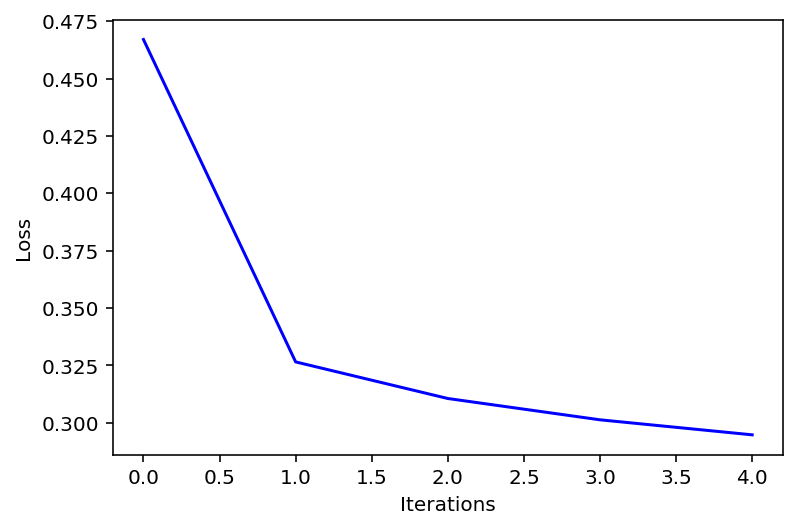

In [9]:
plt.plot(my_LR.loss_during_training,'-b',label='Cross Entropy Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')

To evaluate the performance across the entire test dataset, we will implement a for loop using `testloader` and compute errors per mini-batch. The following code will do the work:

In [10]:
loss = 0
accuracy = 0

# Turn off gradients for validation, saves memory and computations
with torch.no_grad():

    for images,labels in testloader:
        
        probs = my_LR.forward(images.view(images.shape[0], -1))
        
        top_p, top_class = probs.topk(1, dim=1)
        equals = (top_class == labels.view(images.shape[0], 1))
        accuracy += torch.mean(equals.type(torch.FloatTensor))
    

print("Test Accuracy %f" %(accuracy/len(testloader)))

Test Accuracy 0.911724


In [11]:
top_class.shape

torch.Size([16, 1])

With the probabilities, we can get the most likely class using the `probs.topk` method. This returns the $k$ highest values. Since we just want the most likely class, we can use `probs.topk(1)`. This returns a tuple of the top-$k$ values and the top-$k$ indices. If the highest value is the fifth element, we'll get back 4 as the index.

The line 
```python
(top_class == labels.view(images.shape[0], 1))
```
returns a boolean vector of `True/False` values, indicanting werther `top_class` is equeal to `labels` at every position. Finally, with the line

```python
equals.type(torch.FloatTensor)
```
we transform it to real a vector in which `True --> 1.0` and `False --> 0.0`, where we can compute the mean using `torch.mean()`.

> **Excercise** Modify the code of the `Multi_LR_extended` class so it incorporates a method to evaluate the performance in either the train set or the test set (Use a single method with the proper inputs!)

In [0]:
''' This class inherits from the `Multi_LR` class. So it has the same atributes
and methods, and some others that we will add. 
'''
class Multi_LR_extended2(Multi_LR):
    
    def __init__(self,dimx,nlabels,epochs=100,lr=0.001):
        
        super().__init__(dimx,nlabels)  #To initialize `Multi_LR`!
        
        self.lr = lr #Learning Rate
        
        self.optim = optim.Adam(self.parameters(), self.lr)
        
        self.epochs = epochs
        
        self.criterion = nn.NLLLoss()               # NEW w.r.t Lab 1
        
        # A list to store the loss evolution along training
        
        self.loss_during_training = [] 
        
    def train(self,trainloader):
        
       # Optimization Loop
        
        for e in range(int(self.epochs)):
            
            # Random data permutation at each epoch
            
            running_loss = 0.
            
            for images, labels in trainloader:              # NEW w.r.t Lab 1
        
                self.optim.zero_grad()  #TO RESET GRADIENTS!
            
                out = self.forward(images.view(images.shape[0], -1))

                loss = self.criterion(out, labels)

                running_loss += loss.item()

                loss.backward()

                self.optim.step()                
                
            self.loss_during_training.append(running_loss/len(trainloader))

            if(e % 1 == 0): # Every 10 epochs

                print("Training loss after %d epochs: %f" 
                      %(e,self.loss_during_training[-1]))

    def eval_performance(self,dataloader):        
        
        loss = 0
        accuracy = 0

        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():

            for images,labels in dataloader:

              probs = my_LR.forward(images.view(images.shape[0], -1))
        
              top_p, top_class = probs.topk(1, dim=1)
              equals = (top_class == labels.view(images.shape[0], 1))
              accuracy += torch.mean(equals.type(torch.FloatTensor))
    
            return accuracy/len(dataloader)

In [13]:
my_LR = Multi_LR_extended2(dimx=784,nlabels=10,epochs=10,lr=1e-3)

my_LR.train(trainloader)

train_performance = my_LR.eval_performance(trainloader)

test_performance = my_LR.eval_performance(testloader)

print("Train Accuracy %f" %(train_performance))

print("Test Accuracy %f" %(test_performance))

Training loss after 0 epochs: 0.464945
Training loss after 1 epochs: 0.325716
Training loss after 2 epochs: 0.309947
Training loss after 3 epochs: 0.300569
Training loss after 4 epochs: 0.293564
Training loss after 5 epochs: 0.290535
Training loss after 6 epochs: 0.288032
Training loss after 7 epochs: 0.284640
Training loss after 8 epochs: 0.282660
Training loss after 9 epochs: 0.280067
Train Accuracy 0.927139
Test Accuracy 0.922671


Observe that both values are indeed similar, indicating that the model is **biased**. 

Let's check the values for the weight matrix. For a simpler visualization, we will plot the histogram of all the values in the weight matrix.

(array([3.000e+00, 4.000e+00, 3.000e+00, 5.000e+00, 3.000e+00, 9.000e+00,
        5.000e+00, 1.600e+01, 1.100e+01, 1.100e+01, 2.900e+01, 4.000e+01,
        6.000e+01, 8.200e+01, 8.700e+01, 1.610e+02, 1.690e+02, 2.060e+02,
        3.130e+02, 5.110e+02, 7.580e+02, 1.122e+03, 1.087e+03, 8.890e+02,
        5.910e+02, 4.610e+02, 2.590e+02, 2.420e+02, 1.960e+02, 1.740e+02,
        1.190e+02, 6.700e+01, 5.200e+01, 2.900e+01, 2.100e+01, 1.200e+01,
        5.000e+00, 1.100e+01, 6.000e+00, 3.000e+00, 2.000e+00, 1.000e+00,
        2.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 2.000e+00]),
 array([-0.49981314, -0.4774074 , -0.45500165, -0.4325959 , -0.41019017,
        -0.38778442, -0.36537868, -0.34297293, -0.3205672 , -0.29816145,
        -0.2757557 , -0.25334996, -0.23094422, -0.20853847, -0.18613273,
        -0.16372699, -0.14132124, -0.1189155 , -0.09650975, -0.07410401,
        -0.05169827, -0.02929252, -0.00688678,  0.01551896,  0.03792471,
         0.

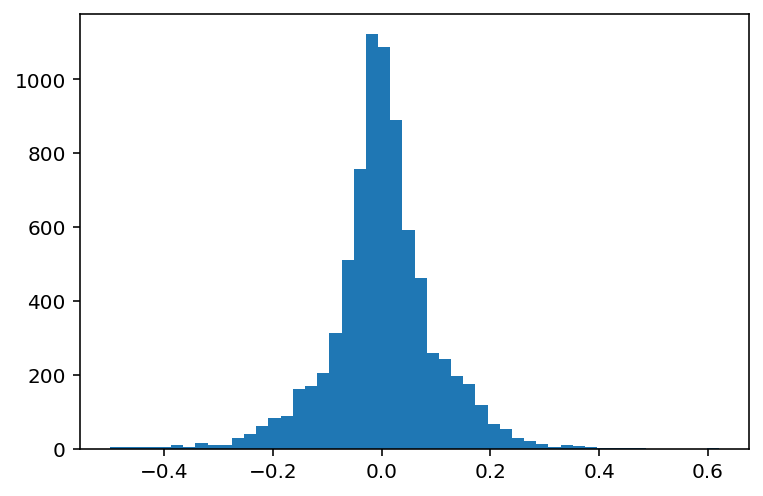

In [14]:
plt.hist(my_LR.output.weight.detach().numpy().reshape([-1,]),50)

## Part III. Train a MLP to do the same job

Modify the code you have just implemented for a MLP is straightforward. Assume we want to train a MLP with three layers, all using rectified linear units (RELU)s as non-linear activations (except the last layer, that uses a Softmax). The first layer has 128 hidden units and the second 64 of them.

In [15]:
Image(url= "https://pytorch.org/docs/stable/_images/ReLU.png", width=600, height=300)

As with the LR, we create a small class defining the model and then a larger class than inherites from it to incorporate methods to perform both training and model evaluation.

> **Exercise**: Complete the code for the following class

In [0]:
class MLP(nn.Module):
    def __init__(self,dimx,hidden1,hidden2,nlabels): #Nlabels will be 10 in our case
        super().__init__()
        
        self.output1 = nn.Linear(dimx,hidden1)
        
        self.output2 = nn.Linear(hidden1,hidden2)
        
        self.output3 = nn.Linear(hidden2,nlabels)
    
        self.relu = nn.ReLU()
        
        self.logsoftmax = nn.LogSoftmax(dim=1)                                                             
        
    def forward(self, x):
        # Pass the input tensor through each of our operations
        
        x = self.relu(self.output1(x))
        x = self.relu(self.output2(x))
        x = self.logsoftmax(self.output3(x))
        
        return x

> **Excercise** Create a class `MLP_extended` that incorporates two methods to the former class. One to perform training and one to perform model evaluation. It is just **one line of code** diferent from the code you have done above for the multi-class LR. This is why I like class and structure my code this way!!

In [0]:
''' This class inherits from the `Multi_LR` class. So it has the same atributes
and methods, and some others that we will add. 
'''
class MLP_extended(MLP):
    
    
    def __init__(self,dimx,hidden1,hidden2,nlabels,epochs=100,lr=0.001):

        super().__init__(dimx,hidden1,hidden2,nlabels)
        
        self.output1 = nn.Linear(dimx,hidden1)
        
        self.output2 = nn.Linear(hidden1,hidden2)
        
        self.output3 = nn.Linear(hidden2,nlabels)
    
        self.relu = nn.ReLU()
        
        self.logsoftmax = nn.LogSoftmax(dim=1)  
        
        self.lr = lr #Learning Rate
        
        self.optim = optim.Adam(self.parameters(), self.lr)
        
        self.epochs = epochs
        
        self.criterion = nn.NLLLoss()               # NEW w.r.t Lab 1
        
        # A list to store the loss evolution along training
        
        self.loss_during_training = [] 
        
    def train(self,trainloader):
        
        # Optimization Loop
        
        for e in range(int(self.epochs)):
            
            # Random data permutation at each epoch
            
            running_loss = 0.
            
            for images, labels in trainloader:              # NEW w.r.t Lab 1
        
                self.optim.zero_grad()  #TO RESET GRADIENTS!
            
                out = self.forward(images.view(images.shape[0], -1))

                loss = self.criterion(out, labels)

                running_loss += loss.item()

                loss.backward()

                self.optim.step()                
                
            self.loss_during_training.append(running_loss/len(trainloader))

            if(e % 1 == 0): # Every 10 epochs

                print("Training loss after %d epochs: %f" 
                      %(e,self.loss_during_training[-1]))

    def eval_performance(self,dataloader):
        
        loss = 0
        accuracy = 0

        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():

            for images,labels in dataloader:

              probs = my_LR.forward(images.view(images.shape[0], -1))
        
              top_p, top_class = probs.topk(1, dim=1)
              equals = (top_class == labels.view(images.shape[0], 1))
              accuracy += torch.mean(equals.type(torch.FloatTensor))
    
            return accuracy/len(dataloader)

Train the model for 10 epochs and compute the train/test performance. How does it compare with the Logistic Regressor?

In [18]:
my_MLP = MLP_extended(dimx=784,hidden1=128,hidden2=64,nlabels=10,epochs=30,lr=1e-3)

my_MLP.train(trainloader)

train_performance = my_MLP.eval_performance(trainloader)

test_performance = my_MLP.eval_performance(testloader)

print("Train Accuracy %f" %(train_performance))

print("Test Accuracy %f" %(test_performance))

Training loss after 0 epochs: 0.392968
Training loss after 1 epochs: 0.187037
Training loss after 2 epochs: 0.136028
Training loss after 3 epochs: 0.109457
Training loss after 4 epochs: 0.092669
Training loss after 5 epochs: 0.082919
Training loss after 6 epochs: 0.070859
Training loss after 7 epochs: 0.066452
Training loss after 8 epochs: 0.058158
Training loss after 9 epochs: 0.052296
Training loss after 10 epochs: 0.049564
Training loss after 11 epochs: 0.045295
Training loss after 12 epochs: 0.043010
Training loss after 13 epochs: 0.038608
Training loss after 14 epochs: 0.037130
Training loss after 15 epochs: 0.032780
Training loss after 16 epochs: 0.032445
Training loss after 17 epochs: 0.030738
Training loss after 18 epochs: 0.026817
Training loss after 19 epochs: 0.028913
Training loss after 20 epochs: 0.027966
Training loss after 21 epochs: 0.023861
Training loss after 22 epochs: 0.025624
Training loss after 23 epochs: 0.022584
Training loss after 24 epochs: 0.022880
Training l

Text(0, 0.5, 'Loss')

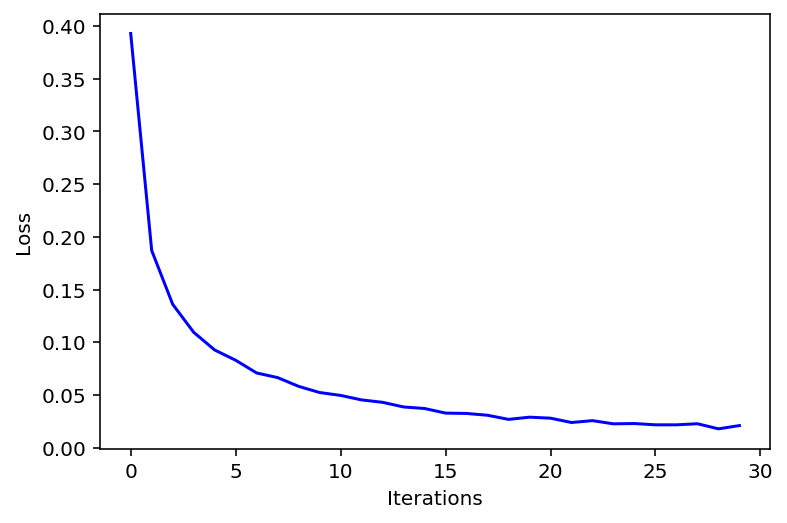

In [19]:
plt.plot(my_MLP.loss_during_training,'-b',label='Cross Entropy Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')

Wow! Performace is almost perfect with a naive Neural Network!!

### Part IV. Saving and restoring the model

Finally, we will show you how to save and load models (i.e. values of the parameters) with PyTorch. This is important because you'll often want to load previously trained models to use in making predictions or to continue training on new data.

As you can imagine, it's impractical to train a network every time you need to use it. Instead, we can save trained networks then load them later to train more or use them for predictions.

The parameters for PyTorch networks are stored in a model's `state_dict`. We can see the state dict contains the weight and bias matrices for each of our layers.

In [20]:
print("Our model: \n\n", my_MLP, '\n')
print("The state dict keys: \n\n", my_MLP.state_dict().keys())

Our model: 

 MLP_extended(
  (output1): Linear(in_features=784, out_features=128, bias=True)
  (output2): Linear(in_features=128, out_features=64, bias=True)
  (output3): Linear(in_features=64, out_features=10, bias=True)
  (relu): ReLU()
  (logsoftmax): LogSoftmax()
  (criterion): NLLLoss()
) 

The state dict keys: 

 odict_keys(['output1.weight', 'output1.bias', 'output2.weight', 'output2.bias', 'output3.weight', 'output3.bias'])


The simplest thing to do is simply save the state dict with `torch.save`. For example, we can save it to a file `'checkpoint.pth'`.

In [0]:
torch.save(my_MLP.state_dict(), 'checkpoint.pth')

Then we can load the state dict with `torch.load`.

In [22]:
state_dict = torch.load('checkpoint.pth')
print(state_dict.keys())

odict_keys(['output1.weight', 'output1.bias', 'output2.weight', 'output2.bias', 'output3.weight', 'output3.bias'])


And to load the state dict in to the network, you do `my_MLP.load_state_dict(state_dict)`.

In [23]:
my_MLP.load_state_dict(state_dict)

<All keys matched successfully>

**Important:** `load_state_dict` will raise an error if the architecture of the network is different from the one saved in the pth file. For example, if we define the following model.

In [0]:
my_MLP2 = MLP_extended(dimx=784,hidden1=256,hidden2=128,nlabels=10,epochs=10,lr=1e-3)

which differs from `my_MLP` in the dimension of the hidden layers, we will get an error if we call the method  `load_state_dict(state_dict)`.

> **Exercise:** Check that you get an error when trying to initialize my_MLP2 from `state_dict` using the method `load_state_dict`

In [27]:
my_MLP2_load_state_dict = my_MLP2.load_state_dict(state_dict)

RuntimeError: ignored